### **3D Protein Image Classification Model**
Image Classification Model that identifies proteins given an mrc file. Credit to [Tensorflow's documentation](https://www.tensorflow.org/tutorials/images/classification) for how to create an image segmentation model using their library.

In [1]:
# run on python 3.9.6
# import the following libraries to use for the model and visualizing its accuracy and loss
import matplotlib.pyplot as plt
import mrcfile
import numpy as np
import os
import pathlib
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### **Download + Explore the Dataset**

In [2]:
data_dir = "../../mrc/atlas-mrc"
data_dir = pathlib.Path(data_dir)

### **Process .mrc files**

In [3]:
batch_size = 4
img_height = img_width = img_depth = 100

In [4]:
def load_mrc_file(file_path):
    with mrcfile.open(file_path) as mrc:
        return mrc.data

In [5]:
def load_mrc_files_from_directory(directory):
    mrc_files = []
    labels = []

    # Iterate over subdirectories (classes)
    class_names = sorted(os.listdir(directory))
    for class_index, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            # Iterate over .mrc files in the current class directory
            for filename in sorted(os.listdir(class_dir)):
                if filename.endswith('.mrc'):
                    file_path = os.path.join(class_dir, filename)
                    # Load .mrc file
                    with mrcfile.open(file_path) as mrc:
                        mrc_data = mrc.data     # alternatively: .astype(np.float32)
                        mrc_files.append(mrc_data)
                        labels.append(class_index)

    return mrc_files, labels, class_names

In [6]:
mrc_files, labels, class_names = load_mrc_files_from_directory(data_dir)

**Data Augmentation**<br>
We will apply random flips and rotations to the input data to prevent against overfitting.

In [7]:
def random_flip_3d(data, seed=123):
    # Generate random integers to determine flip axes
    np.random.seed(seed)
    flip_axes = np.random.randint(0, 2, 3) * 2 - 1  # Either -1 or 1

    # Apply flips
    flipped_data = np.copy(data)
    for axis in range(3):
        if flip_axes[axis] == -1:
            flipped_data = np.flip(flipped_data, axis=axis)
    return flipped_data

In [8]:
from scipy.ndimage import rotate

def random_rotation_3d(data, angle_range=(-10, 10), axes=None, seed=123):
    # Generate random rotation angles for each axis
    if axes is None:
        axes = [(1, 0), (0, 1), (0, 2)]  # Rotation can occur around any axis by default
    
    np.random.seed(seed)
    rotation_angles = np.random.uniform(angle_range[0], angle_range[1], size=(3,))

    # Perform random rotation around each axis
    rotated_data = np.copy(data)
    for axis, angle in zip(axes, rotation_angles):
        rotated_data = rotate(rotated_data, angle, axes=axis, reshape=False, mode='nearest')

    return rotated_data

In [9]:
for i in range(len(mrc_files)):
    mrc_files[i] = random_flip_3d(mrc_files[i], seed=123)
    mrc_files[i] = random_rotation_3d(mrc_files[i], seed=123)

**Add Empty Models**<br>
We don't need to generate empty models using cryotomosim, but we can rather just create empty 100x100x100 numpy arrays, as this will simulate vitreous ice for our model.

In [10]:
def generate_empty_mrc_files(voxel_size=100, total_files=20, num_classes=3):
    mrc_files = []
    labels = []
    class_names = ["empty"]
    
    for i in range(total_files):
        empty_space = np.zeros((voxel_size, voxel_size, voxel_size))
        mrc_data = empty_space.astype(np.float32)
        mrc_files.append(mrc_data)
        labels.append(num_classes)

    return mrc_files, labels, class_names

In [11]:
empty_mrc_files, empty_labels, empty_class_names = generate_empty_mrc_files(voxel_size=100,
                                                                            total_files=20,
                                                                            num_classes=3)

After generating the empty mrc files and labels, append them to the simulated mrc files and labels list.

In [12]:
mrc_files.extend(empty_mrc_files)
labels.extend(empty_labels)
class_names.extend(empty_class_names)

Let's check if the data was properly extended.

In [13]:
print(f"There are {len(mrc_files)} MRC files in total prior to splitting.")
print(f"The first label is {labels[0]} and the last label is {labels[-1]}")
print(f"The first class is {class_names[0]} and the last class is {class_names[-1]}")

There are 80 MRC files in total prior to splitting.
The first label is 0 and the last label is 3
The first class is bltp2 and the last class is empty


**Taking a Look Inside**<br>
Let's verify that the tomograms have been properly loaded.

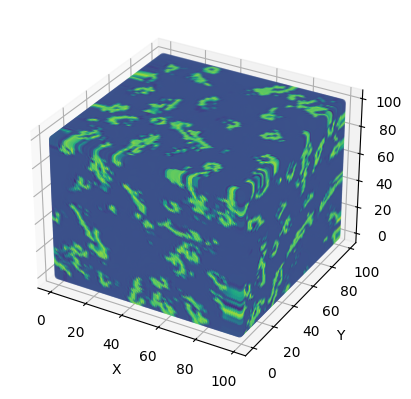

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate a sample 3D numpy array
data = mrc_files[0]  # Replace this with your 3D numpy array

# Create a figure and a 3D Axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Get the shape of the data
x_size, y_size, z_size = data.shape

# Create arrays for the x, y, and z coordinates
x = np.arange(0, x_size)
y = np.arange(0, y_size)
z = np.arange(0, z_size)

# Create a meshgrid from the x, y, and z coordinates
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# Plot the 3D array
ax.scatter(X.flatten(), Y.flatten(), Z.flatten(), c=data.flatten(), cmap='viridis')

# Add labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()


In [15]:
from sklearn.model_selection import train_test_split

# Convert list of 3D numpy arrays to a single 4D numpy array
# Then, convert list of labels to a numpy array
x = np.array(mrc_files)
y = np.array(labels)

# Preprocessing (e.g., normalization)
x_normalized = x / 255.0

# Shuffle data
indices = np.arange(x.shape[0])
x_shuffled = x_normalized[indices]
y_shuffled = y[indices]

# Split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_shuffled, y_shuffled, test_size=0.2, random_state=42)

### **Load data using a Keras utility**

In [16]:
print(f"Training Dataset: {len(x_train)} tomograms and {len(y_train)} labels")
print(f"Validation Dataset: {len(x_val)} tomograms and {len(y_val)} labels")

Training Dataset: 64 tomograms and 64 labels
Validation Dataset: 16 tomograms and 16 labels


In [17]:
print(class_names)

['bltp2', 'coagulation', 'rif1', 'empty']


### **TensorFlow Keras Model**

**Creating the Model**<br>

In [18]:
num_classes = len(class_names)
ks = kernel_size = 5
ps = pool_size = 2

model = Sequential([
  layers.Conv3D(16, (ks, ks, ks), padding='same', activation='relu', input_shape=(img_depth, img_height, img_width, 1)),
  layers.MaxPooling3D((ps, ps, ps)),
  layers.Conv3D(32, (ks, ks, ks), padding='same', activation='relu'),
  layers.MaxPooling3D((ps, ps, ps)),
  layers.Conv3D(64, (ks, ks, ks), padding='same', activation='relu'),
  layers.MaxPooling3D((ps, ps, ps)),
  layers.Conv3D(128, (ks, ks, ks), padding='same', activation='relu'),
  layers.MaxPooling3D((ps, ps, ps)),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

d:\Classes\CS562\ProteinPicker\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


**Compile and Train the Model**

In [19]:
model.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 100, 100, 100,  │         2,016 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 50, 50, 50, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 50, 50, 50, 32) │        64,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 25, 25, 25, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 25, 25, 25, 64) │       256,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 12, 12, 12, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 12, 12, 12,     │     1,024,128 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 6, 6, 6, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 6, 6, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 27648)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     7,078,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,425,412 (32.14 MB)

 Trainable params: 8,425,412 (32.14 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [22]:
epochs = 5
history = model.fit(x_train,
          y_train,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(x_val, y_val),
          callbacks=[callback]
)

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 121s 7s/step - accuracy: 0.3092 - loss: 3.5475 - val_accuracy: 0.1875 - val_loss: 1.3863
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 115s 7s/step - accuracy: 0.2271 - loss: 1.3863 - val_accuracy: 0.1875 - val_loss: 1.3863
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 104s 7s/step - accuracy: 0.2622 - loss: 1.3863 - val_accuracy: 0.1875 - val_loss: 1.3863
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 95s 6s/step - accuracy: 0.2934 - loss: 1.3863 - val_accuracy: 0.1875 - val_loss: 1.3863


In [23]:
import csv
d = history.history

n = len(d["loss"])
with open("empty_callbacks_log.csv", "w") as f:
    csv_writer = csv.writer(f, lineterminator="\n")
    header = ["epoch", "loss", "accuracy", "val_loss", "val_accuracy"]
    csv_writer.writerow(header)

    for i in range(n):
        loss = d["loss"][i]
        accuracy = d["accuracy"][i]
        val_loss = d["val_loss"][i]
        val_accuracy = d["val_accuracy"][i]
        csv_writer.writerow([i, loss, accuracy, val_loss, val_accuracy])

**Visualize Training Results**

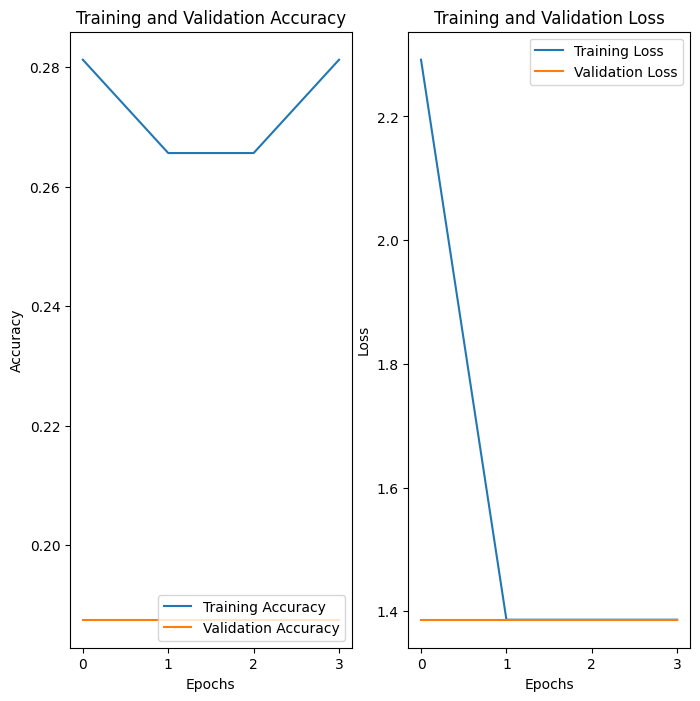

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(n)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and Validation Loss')
plt.show()

### **Predict on New Data**

In [25]:
test_path = "../../mrc/atlas-mrc/bltp2/atlas_BLTP2_4.mrc"
x_test = load_mrc_file(test_path)/255.0
x_test = np.expand_dims(x_test, axis=0)
x_test = x_test.reshape(-1, img_depth, img_height, img_width, 1)

predictions = model.predict(x_test)
score = tf.nn.softmax(predictions[0])

print(
    "This tomogram most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
This tomogram most likely belongs to empty with a 46.78 percent confidence.


### **Save the Model**

In [26]:
model.save('atlas_3d_empty_model.keras')